**Imports and Parameters**

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from IPython.display import HTML

# Make plots display static PNGs in Colab, required for animation setup
%matplotlib inline

# --- Simulation Parameters ---
N = 10  # Number of people
B = 3   # Bar capacity
R = 100 # Number of rounds

**Run the Simulation Algorithm**

In [8]:
# Initialize the state matrix
x = np.zeros((R, N), dtype=int)
x[0, :] = np.random.randint(0, 2, size=N) # Initial random condition

# Algorithm to generate the attendance data for all time steps
for k in range(1, R):
    prev_attendance = np.sum(x[k-1, :])
    if prev_attendance > B:
        x[k, 0] = 0
    elif prev_attendance < B:
        x[k, 0] = 1
    else:
        x[k, 0] = x[k-1, 1]

    # Shift decisions: person i copies person i+1 from the previous step
    x[k, 1:N-1] = x[k-1, 2:N]
    x[k, N-1] = x[k-1, 0]

print("Data generation complete. Shape of x:", x.shape)

Data generation complete. Shape of x: (100, 10)


**Process Data for Plotting**

Data processing complete.


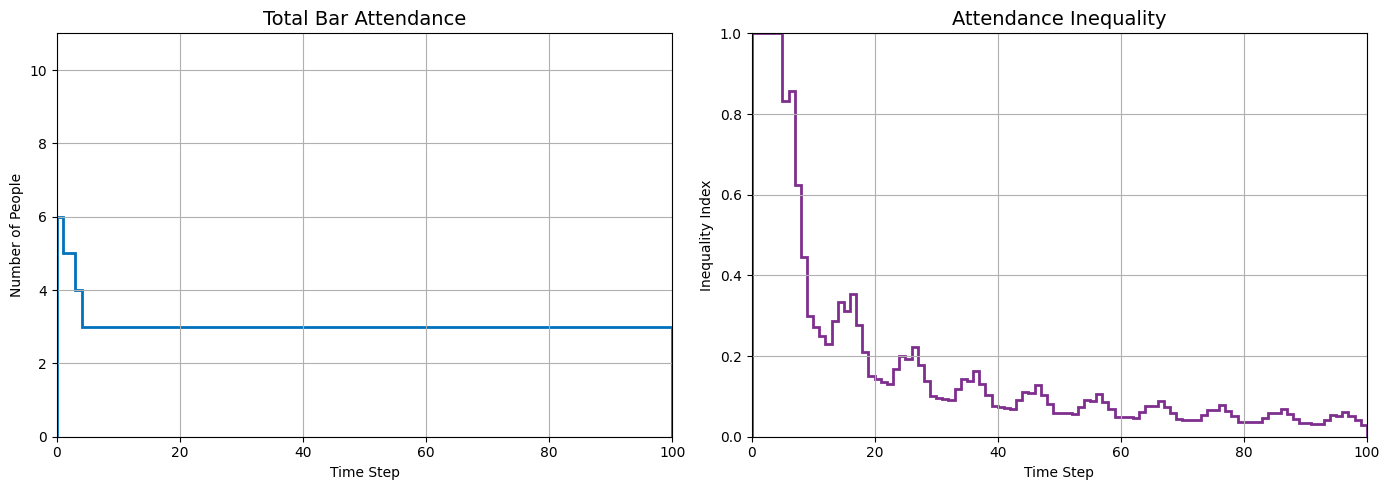

In [9]:
# Calculate cumulative attendance for each person over time
# .cumsum(axis=0) is the efficient NumPy equivalent of your 'asis' loop
asis = x.cumsum(axis=0)

# Calculate inequality over time using vectorized operations
ineq = np.zeros(R)
time_steps = np.arange(1, R + 1)
max_asis = np.max(asis, axis=1)
min_asis = np.min(asis, axis=1)

# A boolean mask to handle cases where max equals min (to avoid division by zero errors)
is_unequal = max_asis != min_asis
ineq[is_unequal] = (max_asis[is_unequal] - min_asis[is_unequal]) / time_steps[is_unequal]

# Calculate total attendance over time for the plot
attendance_over_time = np.sum(x, axis=1)

print("Data processing complete.")

# --- Static Graph Generation ---

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bar Attendance
ax1.stairs(attendance_over_time, linewidth=2, color='#0072BD', fill=False)
ax1.set_title('Total Bar Attendance', fontsize=14)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Number of People')
ax1.set_xlim(0, R)
ax1.set_ylim(0, N + 1)
ax1.grid(True)

# Plot 2: Inequality
ax2.stairs(ineq, linewidth=2, color='#7E2F8E', fill=False)
ax2.set_title('Attendance Inequality', fontsize=14)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Inequality Index')
ax2.set_xlim(0, R)
ax2.set_ylim(0, 1)
ax2.grid(True)

# Display the plots
plt.tight_layout() # Adjusts plot parameters for a tight layout.
plt.show()

**Set Up the Animation Figure and Elements**

In [10]:
# Create the figure and a GridSpec for a more complex layout
fig = plt.figure(figsize=(12, 7), facecolor='w')
gs = fig.add_gridspec(2, 2)

# --- Panel 1: Main Animation ---
ax1 = fig.add_subplot(gs[:, 0]) # Spans both rows on the left
ax1.set_title('Simulation State', fontsize=14)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_xlim(0, 12)
ax1.set_ylim(0, 12)

# Define locations for the bar and homes
bar_center = np.array([6, 6])
home_radius = 4.5
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)

# Draw the bar
bar = Rectangle(bar_center - 1.2, 2.4, 2.4, facecolor='#EDB120', edgecolor='k', lw=2, zorder=0)
ax1.add_patch(bar)
ax1.text(bar_center[0], bar_center[1], 'BAR', ha='center', va='center', fontsize=16, fontweight='bold')

# Draw static home locations and prepare animated person markers
home_pos = np.zeros((N, 2))
people_handles = []
for i in range(N):
    home_pos[i, :] = bar_center + home_radius * np.array([np.cos(angles[i]), np.sin(angles[i])])
    ax1.plot(home_pos[i, 0], home_pos[i, 1], 'sk', markersize=15, c='#77AC30')
    ax1.text(home_pos[i, 0], home_pos[i, 1], str(i + 1), ha='center', va='center', color='w', fontweight='bold')

    person_marker, = ax1.plot([], [], 'o', markersize=14, markeredgecolor='k', lw=2)
    people_handles.append(person_marker)

# --- Panel 2: Bar Attendance Plot ---
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Total Bar Attendance', fontsize=12)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Number of People')
ax2.set_xlim(1, R)
ax2.set_ylim(0, N + 1)
ax2.grid(True)
ax2.axhline(B, color='r', linestyle='--', label=f'Threshold B = {B}')
ax2.legend()
attendance_line, = ax2.plot([], [], lw=2, color='#0072BD', ds='steps-post')

# --- Panel 3: Inequality Plot ---
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_title('Attendance Inequality', fontsize=12)
ax3.set_xlabel('Time Step')
ax3.set_ylabel('Inequality Index')
ax3.set_xlim(1, R)
ax3.set_ylim(0, 1)
ax3.grid(True)
inequality_line, = ax3.plot([], [], lw=2, color='#7E2F8E', ds='steps-post')

# Dynamic text for stats
time_text = ax1.text(0.5, 11.5, '', fontsize=12, fontweight='bold')
attendance_text = ax1.text(0.5, 11.0, '', fontsize=12, fontweight='bold')

fig.tight_layout()

# Close the static plot—we only want to see the final animation
plt.close()

print("Animation setup complete.")

Animation setup complete.


/tmp/ipython-input-1064735203.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sk" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(home_pos[i, 0], home_pos[i, 1], 'sk', markersize=15, c='#77AC30')


**Define Animation Function and Display**

In [11]:
# This function is called for each frame of the animation
def update(k):
    # Update dynamic text
    time_text.set_text(f'Time: {k + 1}/{R}')
    attendance_text.set_text(f'Attendance: {attendance_over_time[k]}')

    # Update the position and color of each person's marker
    for i in range(N):
        if x[k, i] == 1:  # Person 'i' goes to the bar
            pos = bar_center + 0.6 * np.array([np.cos(angles[i]), np.sin(angles[i])])
            color = '#A2142F'  # Red
        else:  # Person 'i' stays home
            pos = home_pos[i, :]
            color = '#4DBEEE'  # Blue

        people_handles[i].set_data([pos[0]], [pos[1]])
        people_handles[i].set_markerfacecolor(color)

    # Update the data in the plots
    x_axis_data = np.arange(1, k + 2)
    attendance_line.set_data(x_axis_data, attendance_over_time[:k+1])
    inequality_line.set_data(x_axis_data, ineq[:k+1])

    # Return a list of all artists that have been modified for blitting
    return people_handles + [time_text, attendance_text, attendance_line, inequality_line]

# Create the animation object
# interval is the delay between frames in milliseconds (e.g., 100ms = 0.1s)
ani = FuncAnimation(fig, update, frames=R, interval=100, blit=True)

# Display the animation as an HTML5 video
HTML(ani.to_html5_video())